In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nihalsrivastava","key":"0ee73569f29d3fcbf29a4e9e5bad989b"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d plhalvorsen/kvasir-v2-a-gastrointestinal-tract-dataset

 99% 2.30G/2.32G [00:22<00:00, 114MB/s]
100% 2.32G/2.32G [00:22<00:00, 112MB/s]


In [6]:
!unzip kvasir-v2-a-gastrointestinal-tract-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: normal-cecum/normal-cecum/00b1b20b-ce2b-449c-93fc-6df854e3ab33.jpg  
  inflating: normal-cecum/normal-cecum/00b99f19-2c31-4c7c-931a-4c3b38d70d1a.jpg  
  inflating: normal-cecum/normal-cecum/00f3d2cc-93ea-40f0-9b88-b159b07a49cb.jpg  
  inflating: normal-cecum/normal-cecum/0111fb06-3113-4abf-9050-7bfb8d4688f5.jpg  
  inflating: normal-cecum/normal-cecum/0163b3a2-9aa1-4b23-a9a8-aff07a738f16.jpg  
  inflating: normal-cecum/normal-cecum/0191eafd-0367-4772-9181-296b80dbf917.jpg  
  inflating: normal-cecum/normal-cecum/01af3454-037f-4708-b73c-6ec4423b6a61.jpg  
  inflating: normal-cecum/normal-cecum/01b9de1c-1481-4056-b27a-4d8fa09da06f.jpg  
  inflating: normal-cecum/normal-cecum/01bddb73-9c5d-4ac0-8b25-cc7524b7d191.jpg  
  inflating: normal-cecum/normal-cecum/01c48bf5-3f79-45dd-9390-add72a6da946.jpg  
  inflating: normal-cecum/normal-cecum/01c49663-9674-44ae-b61e-05243a30e4ab.jpg  
  inflating: normal-cecum/normal-cecum/01c6ae3a

## Transfer Learning: ResNet

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import os
import tensorflow as tf

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [10]:
mkdir dataset

In [11]:
mv dyed-lifted-polyps/dyed-lifted-polyps/ dataset/dyed-lifted-polyps

In [12]:
mv dyed-resection-margins/dyed-resection-margins/ dataset/dyed-resection-margins/

In [13]:
mv esophagitis/esophagitis/ dataset/esophagitis/

In [14]:
mv normal-cecum/normal-cecum/ dataset/normal-cecum/

In [15]:
train_dataset = tf.keras.utils.image_dataset_from_directory("./dataset",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 4000 files belonging to 4 classes.


In [16]:
class_names = train_dataset.class_names
class_names

['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum']

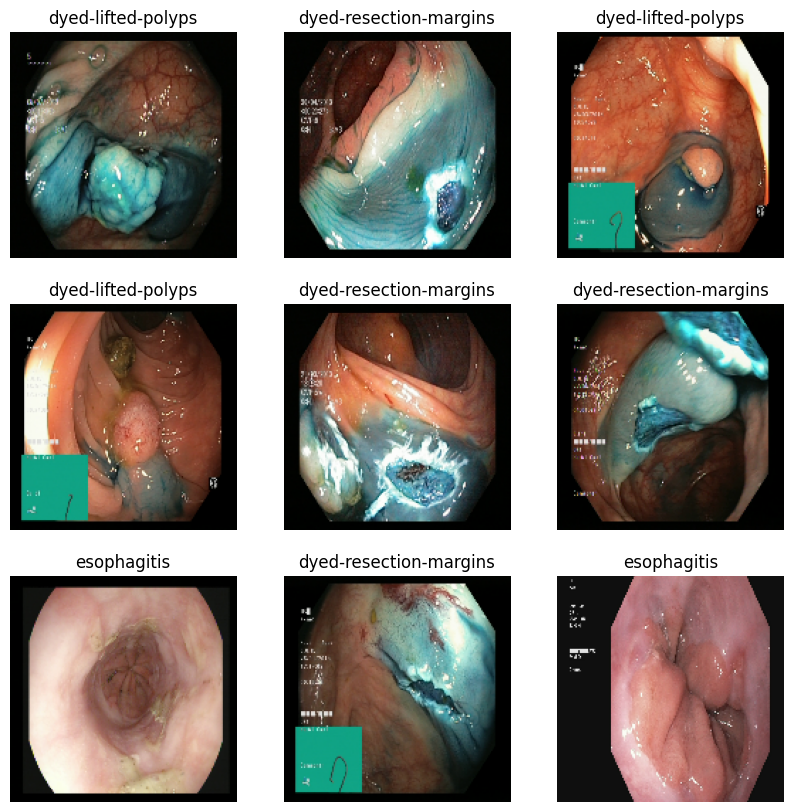

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
labels

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 0, 0, 1, 1, 2, 1, 2, 2, 2, 2, 3, 3, 3, 0, 3, 0, 0, 0, 3, 0,
       1, 3, 2, 1, 0, 0, 2, 2, 0, 3], dtype=int32)>

In [19]:
images[i].shape

TensorShape([160, 160, 3])

In [20]:
base_model = tf.keras.applications.ResNet50(input_shape=(160, 160, 3), include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [21]:
import tensorflow.keras.applications.resnet50 as resnet50

In [22]:
preprocess = resnet50.preprocess_input

In [23]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [24]:
base_model.trainable = False

In [25]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 166, 166, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 80, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 80, 80, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [27]:
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [28]:
inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________

In [30]:
len(model.trainable_variables)

2

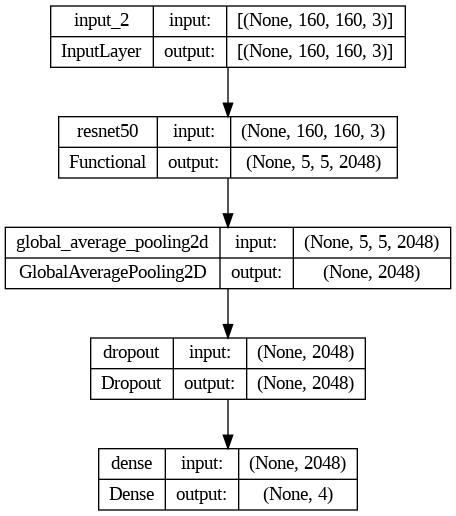

In [31]:
tf.keras.utils.plot_model(model, to_file='ResNet10.png', show_shapes=True)

In [32]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [33]:
val_dataset = train_dataset.take(2000)

In [34]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
125/125 [==============================] - 55s 382ms/step - loss: 1.2861 - accuracy: 0.5030 - val_loss: 0.5851 - val_accuracy: 0.7755
Epoch 2/10
125/125 [==============================] - 68s 538ms/step - loss: 0.5574 - accuracy: 0.7810 - val_loss: 0.3673 - val_accuracy: 0.8637
Epoch 3/10
125/125 [==============================] - 59s 465ms/step - loss: 0.4130 - accuracy: 0.8410 - val_loss: 0.2980 - val_accuracy: 0.8890
Epoch 4/10
125/125 [==============================] - 69s 542ms/step - loss: 0.3515 - accuracy: 0.8673 - val_loss: 0.2619 - val_accuracy: 0.8997
Epoch 5/10
125/125 [==============================] - 47s 371ms/step - loss: 0.3106 - accuracy: 0.8792 - val_loss: 0.2407 - val_accuracy: 0.9075
Epoch 6/10
125/125 [==============================] - 49s 387ms/step - loss: 0.2793 - accuracy: 0.8878 - val_loss: 0.2242 - val_accuracy: 0.9085
Epoch 7/10
125/125 [==============================] - 48s 372ms/step - loss: 0.2678 - accuracy: 0.8848 - val_loss: 0.2131 - val_ac

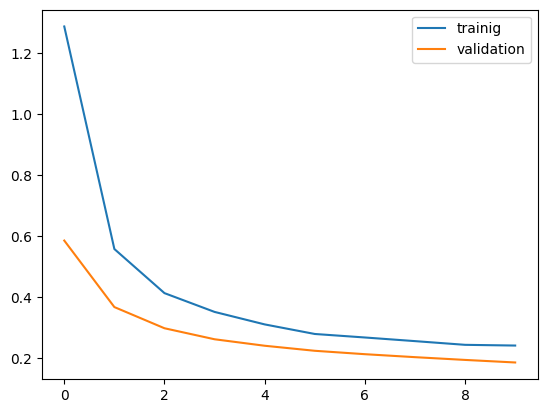

In [35]:
plt.plot(history.history['loss'], label="trainig")
plt.plot(history.history['val_loss'], label="validation")
plt.legend()

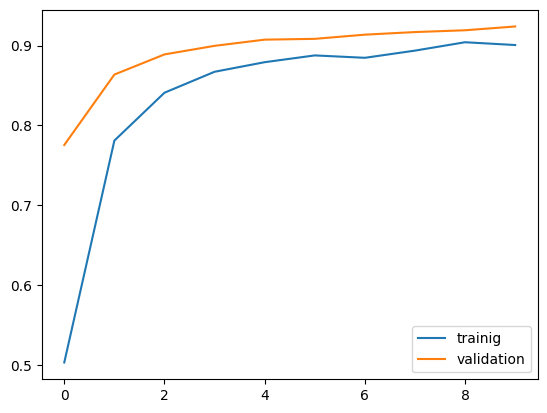

In [36]:
plt.plot(history.history['accuracy'], label="trainig")
plt.plot(history.history['val_accuracy'], label="validation")
plt.legend()

In [ ]:
model.save('../models/resnet_10eph')

INFO:tensorflow:Assets written to: ../models/resnet_10eph\assets


INFO:tensorflow:Assets written to: ../models/resnet_10eph\assets


In [ ]:
model = tf.keras.models.load_model('../models/resnet_10eph/')

In [37]:
def input_img(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224,224])
    return image

def normalize_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm

def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="ocean")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "ocean")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "ocean" )
    plt.axis("off")

### Saliency Maps Visulization

In [40]:
tumor_img = input_img('./dataset/dyed-lifted-polyps/0053d7cd-549c-48cd-b370-b4ad64a8098a.jpg')
cyst_img = input_img('./dataset/dyed-resection-margins/003808ff-c349-481a-9c91-e9acf1c181b7.jpg')
stone_img = input_img('./dataset/esophagitis/011b08eb-9305-4306-9d58-7623ddc54097.jpg')
normal_img = input_img('./dataset/normal-cecum/01af3454-037f-4708-b73c-6ec4423b6a61.jpg')

In [41]:
tumor_img = tf.image.resize(tumor_img, size=IMG_SIZE)
cyst_img = tf.image.resize(cyst_img, size=IMG_SIZE)
stone_img = tf.image.resize(stone_img, size=IMG_SIZE)
normal_img = tf.image.resize(normal_img, size=IMG_SIZE)

Tumor

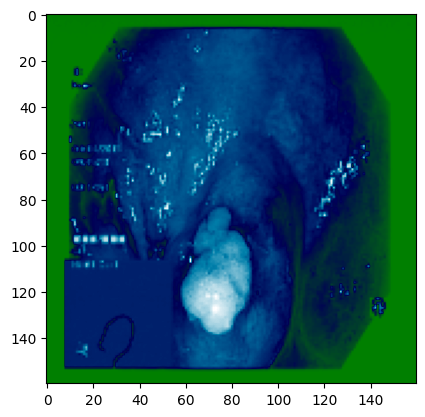

In [42]:
img = tf.reshape(tumor_img, shape=(160, 160, 3))
plt.imshow(normalize_image(img), cmap = "ocean")

In [43]:
result = model(tumor_img)
max_idx = tf.argmax(result, axis=1)

with tf.GradientTape() as tape:
    tape.watch(tumor_img)
    result = model(tumor_img)
    max_score = result[0,max_idx[0]]

grads = tape.gradient(max_score, tumor_img)

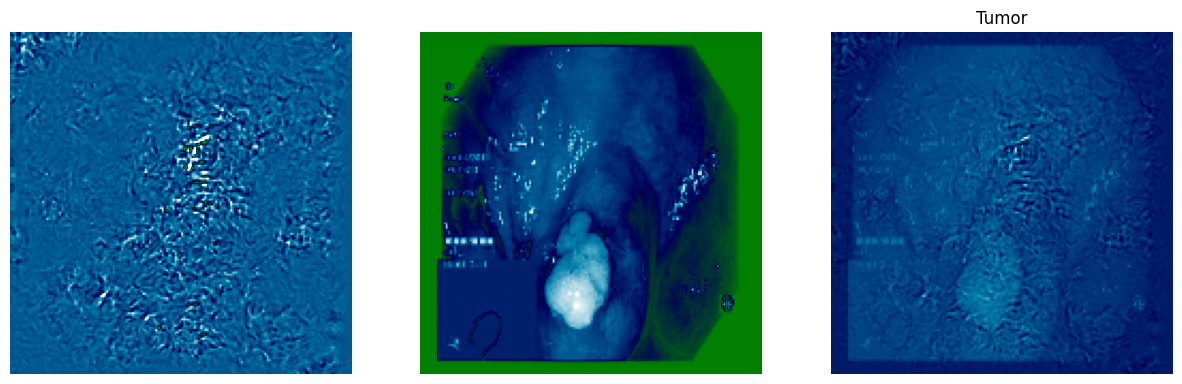

In [44]:
index = 0
plot_maps(normalize_image(grads[index]), normalize_image(img))
plt.title("Tumor");

Cyst

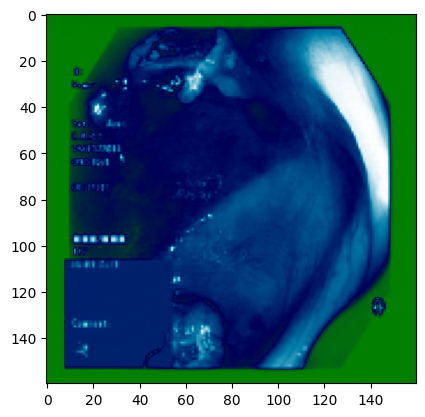

In [45]:
img = tf.reshape(cyst_img, shape=(160, 160, 3))
plt.imshow(normalize_image(img), cmap = "ocean")

In [46]:
result = model(cyst_img)
max_idx = tf.argmax(result, axis=1)

with tf.GradientTape() as tape:
    tape.watch(cyst_img)
    result = model(cyst_img)
    max_score = result[0,max_idx[0]]

grads = tape.gradient(max_score, cyst_img)

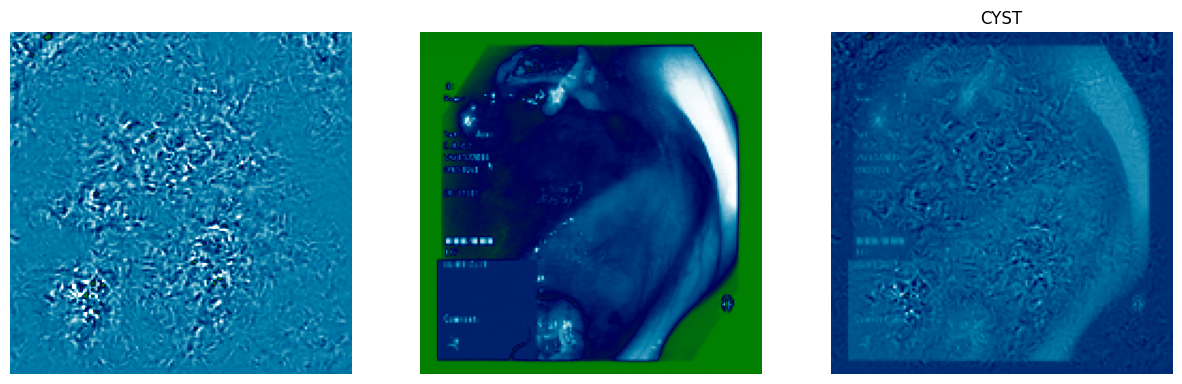

In [47]:
index = 0
plot_maps(normalize_image(grads[index]), normalize_image(img))
plt.title("CYST");

Stone

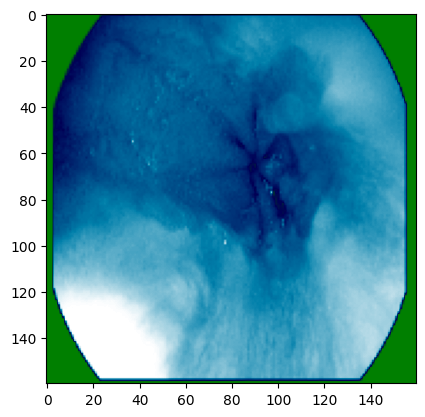

In [48]:
img = tf.reshape(stone_img, shape=(160, 160, 3))
plt.imshow(normalize_image(img), cmap = "ocean")

In [49]:
result = model(stone_img)
max_idx = tf.argmax(result, axis=1)

with tf.GradientTape() as tape:
    tape.watch(stone_img)
    result = model(stone_img)
    max_score = result[0,max_idx[0]]

grads = tape.gradient(max_score, stone_img)

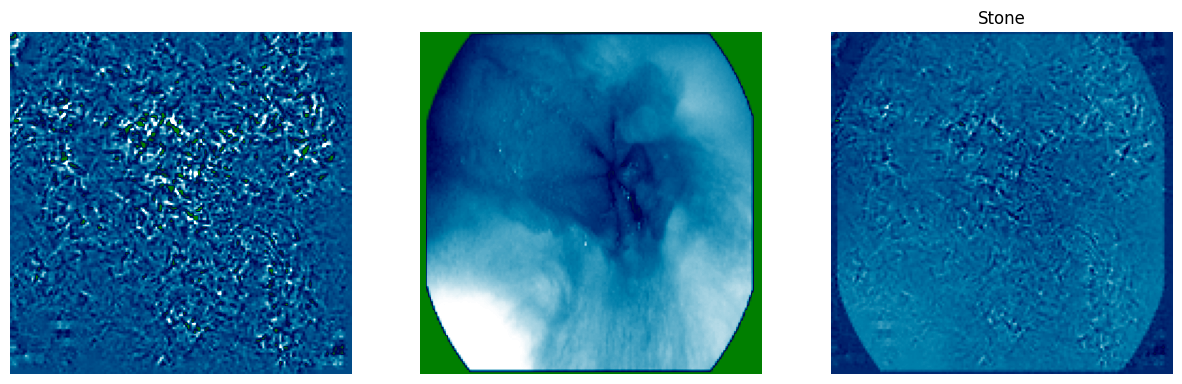

In [50]:
index = 0
plot_maps(normalize_image(grads[index]), normalize_image(img))
plt.title("Stone");

Normal

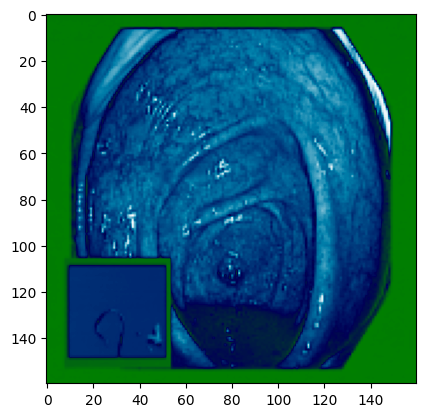

In [51]:
img = tf.reshape(normal_img, shape=(160, 160, 3))
plt.imshow(normalize_image(img), cmap = "ocean")

In [52]:
result = model(normal_img)
max_idx = tf.argmax(result, axis=1)

with tf.GradientTape() as tape:
    tape.watch(normal_img)
    result = model(normal_img)
    max_score = result[0,max_idx[0]]

grads = tape.gradient(max_score, normal_img)

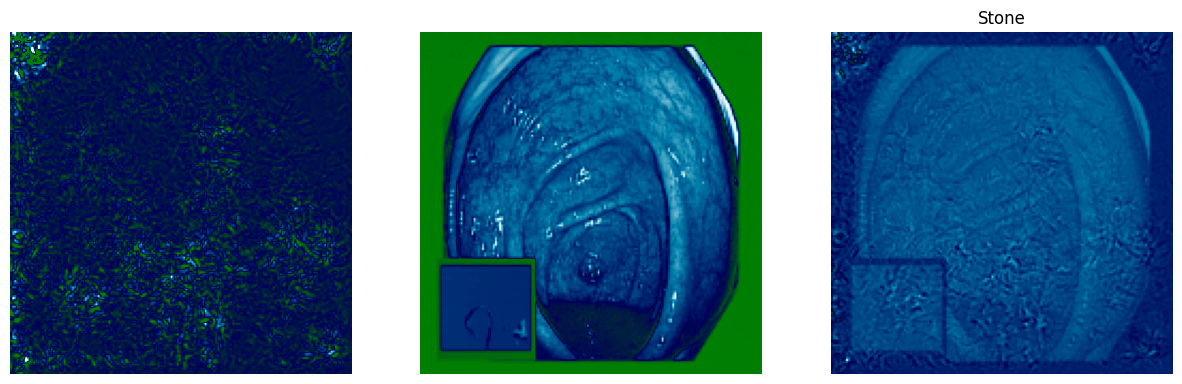

In [53]:
index = 0
plot_maps(normalize_image(grads[index]), normalize_image(img))
plt.title("Stone");